# Abstract

**Author:** [Charles Tapley Hoyt](https://github.com/cthoyt)

**Estimated Run Time:** 4 minutes

This notebooks demonstrates the usage of a variant  the [Network Perturbation Amplitude](http://bmcsystbiol.biomedcentral.com/articles/10.1186/1752-0509-6-54) algorithm to analyze an BEL knowledge assembly in the context of a differential gene expression experiment. 

### Notebook Imports

In [1]:
import logging
import os
import sys
import time

import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
from pandas.tools.plotting import scatter_matrix
from matplotlib_venn import venn2
from tqdm import tqdm

import pybel
import pybel_tools
from pybel_tools.analysis.heat import Runner, multirun, workflow_aggregate
from pybel.constants import *
from pybel.canonicalize import calculate_canonical_name
from pybel_tools.visualization import to_jupyter
from pybel_tools.integration import overlay_type_data
from pybel_tools.summary import print_summary
import seaborn as sns

In [2]:
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

### Notebook Provenance

The time of execution, random number generator seed, and the versions of the software packages used are displayed explicitly.

In [3]:
print(sys.version)

3.6.5 (default, Apr 25 2018, 14:23:58) 
[GCC 4.2.1 Compatible Apple LLVM 9.1.0 (clang-902.0.39.1)]


In [4]:
print(time.asctime())

Wed Jun 20 14:46:32 2018


In [5]:
pybel.utils.get_version()

'0.11.4-dev'

In [6]:
pybel_tools.utils.get_version()

'0.5.3-dev'

In [7]:
# seed the random number generator
import random

random.seed(127)

### Local Path Definitions

To make this notebook interoperable across many machines, locations to the repositories that contain the data used in this notebook are referenced from the environment, set in `~/.bashrc` to point to the place where the repositories have been cloned. Assuming the repositories have been `git clone`'d into the `~/dev` folder, the entries in `~/.bashrc` should look like:

```bash
...
export BMS_BASE=~/dev/bms
...
```

#### BMS 

The biological model store (BMS) is the internal Fraunhofer SCAI repository for keeping BEL models under version control. It can be downloaded from https://tor-2.scai.fraunhofer.de/gf/project/bms/

In [8]:
bms_base = os.environ["BMS_BASE"]

#### OwnCloud

The differential gene expression data used in this notebook is currently not published, and is obfuscated with reference through our team's internal data storage system with [OwnCloud](https://owncloud.org/).

In [9]:
owncloud_base = os.environ["OWNCLOUD_BASE"]

# Data

## Alzheimer's Disease Knowledge Assembly

The Alzheimer's Disease Knowledge Assembly has been precompiled with the following command line script, and will be loaded from this format for improved performance. In general, derived data, such as the gpickle representation of a BEL script, are not saved under version control to ensure that the most up-to-date data is always used.

```sh
pybel convert --path "$BMS_BASE/aetionomy/alzheimers.bel" --pickle "$BMS_BASE/aetionomy/alzheimers.gpickle"
```

The BEL script can also be compiled from inside this notebook with the following python code:

```python
>>> import os
>>> import pybel
>>> # Input from BEL script
>>> bel_path = os.path.join(bms_base, 'aetionomy', 'alzheimers.bel')
>>> graph = pybel.from_path(bel_path)
>>> # Output to gpickle for fast loading later
>>> pickle_path = os.path.join(bms_base, 'aetionomy', 'alzheimers.gpickle')
>>> pybel.to_pickle(graph, pickle_path)
```

In [10]:
pickle_path = os.path.join(bms_base, "aetionomy", "alzheimers", "alzheimers.gpickle")

In [11]:
graph = pybel.from_pickle(pickle_path)

In [12]:
print(graph)

Alzheimer's Disease Knowledge Assembly v5.0.5


All orthologies are discared before analysis.

In [13]:
pybel_tools.filters.remove_nodes_by_namespace(graph, "MGI")
pybel_tools.filters.remove_nodes_by_namespace(graph, "RGD")

To merge the differential gene expression annotations, the entire graph is collapsed to genes using [pybel_tools.mutation.collapse_by_central_dogma_to_genes](http://pybel-tools.readthedocs.io/en/latest/mutation.html#pybel_tools.mutation.collapse_by_central_dogma_to_genes)

In [14]:
pybel_tools.mutation.collapse_by_central_dogma_to_genes(graph)
pybel_tools.mutation.rewire_variants_to_genes(graph)

In [15]:
print_summary(graph)

Nodes: 4007
Edges: 15140
Citations: 1816
Authors: 0
Network density: 0.0009431821820550931
Components: 73
Average degree: 3.7783878213127027
Compilation warnings: 1435


## Differential Gene Expression

Differential gene expression data can be obtained from many sources, including ADNI and other large clinical studies. This analysis is concerned with the log-fold-changes on each gene, and not necessarily the p-value. This is better as a data-driven process becuase it does not require a model or multiple hypothesis testing on raw data.

In [16]:
data_path = os.path.join(owncloud_base, "projects", "alzheimers", "SevAD.csv")

assert os.path.exists(data_path), "Data does not exist!"

In [17]:
df = pd.read_csv(data_path)

In [18]:
target_columns = ["Gene.symbol", "logFC"]

# Check that the columns are named properly
for target_column in target_columns:
    assert target_column in df.columns

In [19]:
# throw away columns that don't have gene symbols - these represent control sequences
df = df.loc[df["Gene.symbol"].notnull(), target_columns]

In [20]:
# show a summary
df.head()

,Gene.symbol,logFC
0,ZNF616,-4.244691
1,DEFB125,3.974393
3,SNAP23,3.337636
4,PHLDB2,3.192559
5,LOC389895,-4.296850


## Data Summary

On the left, the number of shared elements in the knowledge assembly and differential gene data set are counted.

On the right, a histogram of the log-fold-changes shows that the data are normally distributed, as expected for differential gene expression data.

In [21]:
# Get all HGNC symbols from the BEL graph
hgnc_names = pybel.struct.summary.get_names_by_namespace(graph, "HGNC")

# Get all HGNC symbols from the differential gene expression data set
df_names = set(df["Gene.symbol"])

# Calculate the intersection of the two gene symbol lists
overlapping_hgnc_names = hgnc_names & df_names

In [22]:
# The function pybel_tools.integration.overlay_type_data requires a dictionary from gene symbol to log fold changes
data = {gene_symbol: log_fc for _, gene_symbol, log_fc in df.itertuples()}

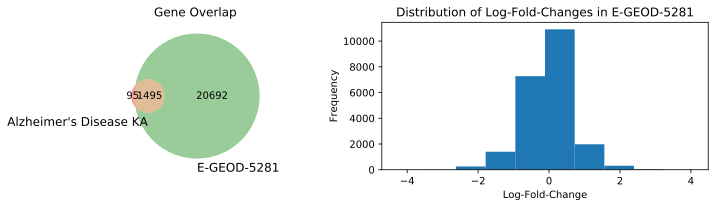

In [23]:
fix, (rax, lax) = plt.subplots(1, 2, figsize=(10, 3))

lax.set_title("Distribution of Log-Fold-Changes in E-GEOD-5281")
lax.set_xlabel("Log-Fold-Change")
lax.set_ylabel("Frequency")
lax.hist(list(data.values()))

rax.set_title("Gene Overlap")
venn2(
    [hgnc_names, df_names], set_labels=["Alzheimer's Disease KA", "E-GEOD-5281"], ax=rax
)
plt.tight_layout()
plt.show()

# Analysis

## Data Integration

Finally, the differential gene expression data are ovelayed on the BEL graph with [pybel_tools.integration.overlay_type_data](http://pybel-tools.readthedocs.io/en/latest/integration.html#pybel_tools.integration.overlay_type_data)

In [24]:
overlay_type_data(graph, data, GENE, "HGNC", overwrite=False, impute=0)

## Subgraph Generation

A subgraph is induced around an example biological process, Inflammatory Response, by selecting all of the source nodes of upstream causal edges, where this process is the target node. These networks are then enriched by expandind around all of those nodes' upstream edges as well.

In [25]:
inflamation_node = BIOPROCESS, "GOBP", "inflammatory response"

### Iteration 1/2

All of the nodes that have upstream causal relations to Inflammatory Response are added.

In [26]:
subgraph = pybel_tools.mutation.get_upstream_causal_subgraph(graph, inflamation_node)

print_summary(subgraph)
to_jupyter(subgraph)

Nodes: 41
Edges: 49
Citations: 25
Authors: 0
Network density: 0.029878048780487804
Components: 1
Average degree: 1.1951219512195121


<IPython.core.display.Javascript object>

### Iteration 2/2

All of the nodes upstream of the nodes within the subgraph are added as well.

In [27]:
pybel_tools.mutation.expand_upstream_causal_subgraph(graph, subgraph)
print_summary(subgraph)

Nodes: 343
Edges: 763
Citations: 423
Authors: 0
Network density: 0.006504356128416279
Components: 1
Average degree: 2.2244897959183674


### Post-Processing

Inconsistient edges are thrown away, literature bias is removed, and nodes on the periphery of the subgraph that are not annotated with experimental data are also removed, since they cannot contribute to the propogation of scores.

In [28]:
pybel_tools.mutation.remove_inconsistent_edges(graph)

In [29]:
pybel_tools.mutation.collapse_consistent_edges(graph)

In [30]:
pybel_tools.generation.remove_unweighted_leaves(subgraph)

In [31]:
pybel_tools.generation.remove_unweighted_sources(subgraph)

In [32]:
print_summary(subgraph)
to_jupyter(subgraph)

Nodes: 181
Edges: 520
Citations: 323
Authors: 0
Network density: 0.01596071209330878
Components: 1
Average degree: 2.8729281767955803


<IPython.core.display.Javascript object>

This entire procedure can be run automatically with [pybel_tools.generation.generate_mechanism](http://pybel-tools.readthedocs.io/en/latest/generation.html#pybel_tools.generation.generate_mechanism)

## Running

In [33]:
runner = Runner(subgraph, inflamation_node)

While the algorithm can be immediately run with [pybel_tools.analysis.heat.Runner.run](http://pybel-tools.readthedocs.io/en/latest/heat.html#pybel_tools.analysis.heat.Runner.run), the process is outlined to show the evolution of the graph throughouts its steps. For animation purposes, the functin [pybel_tools.analysis.heat.Runner.run_with_graph_transformation](http://pybel-tools.readthedocs.io/en/latest/heat.html#pybel_tools.analysis.heat.Runner.run_with_graph_transformation) yields a new `BELGraph` at each step through the process as well.

In [34]:
leaves = runner.score_leaves()

for leaf in leaves:
    print(f"Leaf: {graph.node_to_bel(leaf)}")

to_jupyter(runner.get_remaining_graph(), height=400)

Leaf: g(HGNC:TREM2)
Leaf: g(HGNC:IRAK1)
Leaf: g(HGNC:PTGS2)
Leaf: a(MESHCS:"Neurofibrillary Tangles")
Leaf: g(HGNC:CHI3L1)
Leaf: g(HGNC:CFH)
Leaf: a(CHEBI:leukotriene)
Leaf: g(HGNC:IRAK2)


<IPython.core.display.Javascript object>

In [35]:
leaves = runner.score_leaves()

for leaf in leaves:
    print(f"Leaf: {graph.node_to_bel(leaf)}")

to_jupyter(runner.get_remaining_graph(), height=400)

no leaves.


<IPython.core.display.Javascript object>

In [36]:
leaves = runner.score_leaves()

for leaf in leaves:
    print(f"Leaf: {graph.node_to_bel(leaf)}")

to_jupyter(runner.get_remaining_graph(), height=400)

no leaves.


<IPython.core.display.Javascript object>

In [37]:
runner.remove_random_edge()

to_jupyter(runner.get_remaining_graph(), height=400)

<IPython.core.display.Javascript object>

In [38]:
runner.score_leaves()

no leaves.


set()

In [39]:
runner.score_leaves()

no leaves.


set()

In [40]:
runner.remove_random_edge()
leaves = runner.score_leaves()
len(leaves)

1

In [41]:
to_jupyter(runner.get_remaining_graph(), height=400)

<IPython.core.display.Javascript object>

In [42]:
runner.run()

In [43]:
runner.get_final_score()

77.20570941000088

## Robustness Analysis

The algorithm is random, so it can be run multiple times to assess the robustness of the final scores using [pybel_tools.analysis.heat.multirun](http://pybel-tools.readthedocs.io/en/latest/heatdiffusion.html#pybel_tools.analysis.heat.multirun)

In [44]:
%%time
runners = list(multirun(subgraph, inflamation_node, runs=500, use_tqdm=True))

100%|██████████| 500/500 [00:22<00:00, 22.01it/s]

CPU times: user 22 s, sys: 423 ms, total: 22.4 s
Wall time: 22.7 s


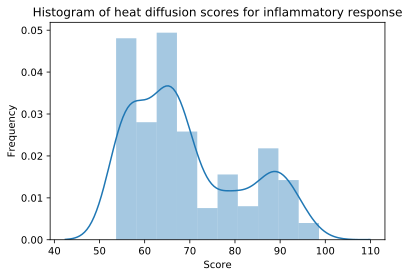

In [45]:
sns.distplot([runner.get_final_score() for runner in runners])
plt.title(
    f"Histogram of heat diffusion scores for {calculate_canonical_name(subgraph, inflamation_node)}"
)
plt.ylabel("Frequency")
plt.xlabel("Score")
plt.show()

## Full Workflow

This workflow can all be run with [pybel_tools.analysis.heat.workflow_all_average](http://pybel-tools.readthedocs.io/en/latest/heat.html#pybel_tools.analysis.heat.workflow_all_average) but is outlined here for a deeper understanding.

### Generate Candidate Mechanisms

Candidate mechanism are generated with the aforementioned function [pybel_tools.generation.generate_mechanism](http://pybel-tools.readthedocs.io/en/latest/generation.html#pybel_tools.generation.generate_mechanism) to assess the upstream causal subgraphs of all biological processes.

In [46]:
all_bioprocesses = list(pybel_tools.filters.get_nodes_by_function(graph, BIOPROCESS))

print(f"There are {len(all_bioprocesses)} bioprocesses")

There are 426 bioprocesses


In [47]:
%%time
candidate_mechanisms = {
    node: pybel_tools.generation.generate_mechanism(graph, node)
    for node in all_bioprocesses
}

CPU times: user 610 ms, sys: 15.8 ms, total: 626 ms
Wall time: 628 ms


The algorithm is run over all candidate subgraphs that are nontrivial (have more than one node in them) and a pandas DataFrame is prepared.

In [48]:
%%time

scores = {}

for node, subgraph in tqdm(
    candidate_mechanisms.items(), total=len(candidate_mechanisms)
):

    fneighbors = subgraph.in_degree(node)
    fneighbors = 0 if isinstance(fneighbors, dict) else fneighbors
    size = subgraph.number_of_nodes()

    if size <= 1:  # Can't calculate a score for empty subgraphs
        average_score = None
    else:
        average_score = workflow_aggregate(subgraph, node, aggregator=np.mean)

    scores[node] = (average_score, fneighbors, size)

100%|██████████| 426/426 [01:40<00:00,  4.25it/s]

CPU times: user 1min 39s, sys: 1.01 s, total: 1min 40s
Wall time: 1min 40s


In [49]:
len(candidate_mechanisms), sum(1 for score, _, _ in scores.values() if score)

(426, 215)

In [50]:
# Optionally, calcualte "cute names" for the nodes
# scores = {calculate_canonical_name(graph, n): s for n, s in scores.items()}

scores_df = pd.DataFrame.from_items(
    scores.items(),
    orient="index",
    columns=["Average Score", "Number First Neighbors", "Subgraph Size"],
)

A scatter matrix is shown below. The distribution of average scores is shown to be mostly normal. The following scatter plots show small, non-linear relationships between average score and the subgraph size and the number of first neighbors of the seed node. The trivial positive correlation between number of first neighbors is also shown.

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  """Entry point for launching an IPython kernel.


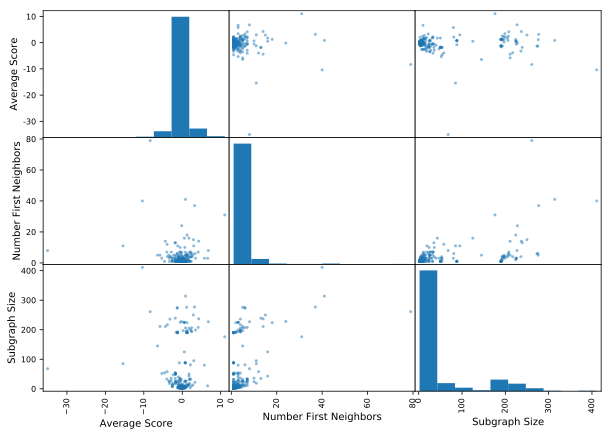

In [51]:
scatter_matrix(scores_df[scores_df["Average Score"].notnull()], figsize=(10, 7))
plt.show()

In [52]:
scores_df.to_csv(os.path.expanduser("~/Desktop/heat_diffusion_demo.csv"))

In [53]:
scores_df[scores_df["Average Score"].notnull()].sort_values("Average Score")

,Average Score,Number First Neighbors,Subgraph Size
"(BiologicalProcess, GOBP, glial cell differentiation)",-35.037175,8,68
"(BiologicalProcess, GOBP, production of molecular mediator involved in inflammatory response)",-15.415658,11,85
"(BiologicalProcess, GOBP, neuron apoptotic process)",-10.366053,40,411
"(BiologicalProcess, GOBP, apoptotic process)",-8.337959,79,261
"(BiologicalProcess, GOBP, cell migration)",-6.422840,5,145
"(BiologicalProcess, GOBP, chronic inflammatory response)",-5.793031,5,211
"(BiologicalProcess, GOBP, cell-matrix adhesion)",-5.314752,3,52
"(BiologicalProcess, GOBP, negative regulation of microtubule depolymerization)",-4.608462,1,54
"(BiologicalProcess, GOBP, beta-amyloid formation)",-4.393178,14,211
"(BiologicalProcess, GOBP, phagocytosis)",-4.013165,7,33


# Conclusions

## Problems

This algorithm overcomes deterministic problems with cyclic graphs by randomly removing edges. It can be run multiple times to assess the stability of the score with `pybel_tools.analysis.heat.average_run`. The effect of the default score can also be checked with a grid search.

## Looking Forward

While this new algorithm is generally applicable and overcomes the original algorithm, it must throw away information to do so. Further algorithmic development, such as heat diffusion approaches could allow for a more thorough investigation of the propogation of effects of the differential gene expression.

This algorithm can be run over the mechanisms generated for each biological process. Further investigation into the upstream mechanism generation can yield bias-free candidate mechanisms. They can also be matched to canonical mechanisms in NeuroMMSigDB to identify concordance between the biological dogma and all possible mechanisms, then to identify previously unknown cross-talk between mechanisms.